In this task, I built a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment.

In [ ]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values


In [ ]:
# Take a look at some reviews
for i in range(6):
  print(X[i], y[i], '\n')


I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the

Most of the data (comments) are written diligently, which makes them long and rich.
There are many information with sentiment to be captured.
Also, data balance is very well with an equal amount of positive and negative reviews.
It is a high-quality dataset for sentiment analysis.

Possible challenges including mixed sentiments within one review, using narration instead of adjectives, or even sarcasm.
For example, if you read the start of the second comment (which is negative) printed above, you might think it is positive.
In the body of the comment, the commenter showed his dislike by comparing it to Australian soap opera instead of saying out directly.
And there are typos and untranslatable emojis that can be misleading.
Take the last comment printed above (which is positive) as an example.
It seems to have used the same emoji as the second last one, while the two are actually sentimentally opposite.
Also I think the sentence 'his died dies' has a typo, or else it is not coherent.

Average character length per review: 1311.239225
Length of the longest review: 13704
Length of the shortest review: 32
Number of positive reviews: 20004
Number of negative reviews: 19996


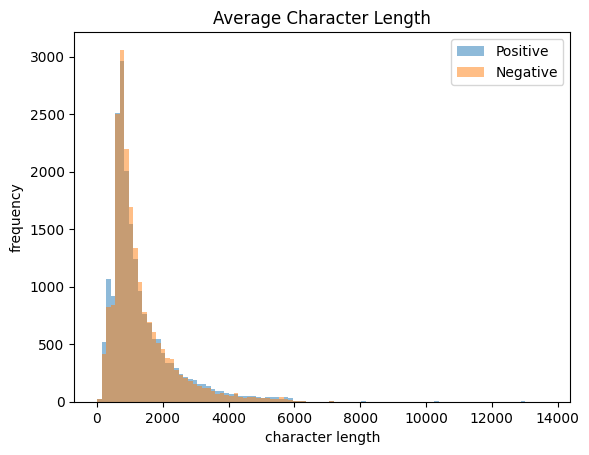

In [ ]:
# Dataset overview
avg_ch_len = len(''.join(X)) / len(X)
print("Average character length per review:", avg_ch_len)

ch_len = [len(x) for x in X]
print("Length of the longest review:", max(ch_len))
print("Length of the shortest review:", min(ch_len))

num_pos, num_neg = sum([1 for i in y if i == 'positive']), sum([1 for i in y if i == 'negative'])
print("Number of positive reviews:", num_pos)
print("Number of negative reviews:", num_neg)

pos_rev, neg_rev = [len(X[i]) for i in range(len(X)) if y[i] == 'positive'], [len(X[i]) for i in range(len(X)) if y[i] == 'negative']
bins = np.linspace(0, max(max(pos_rev), max(neg_rev)), 100)
plt.hist(pos_rev, bins=bins, alpha=0.5, label='Positive')
plt.hist(neg_rev, bins=bins, alpha=0.5, label='Negative')
plt.title('Average Character Length')
plt.xlabel('character length')
plt.ylabel('frequency')
plt.legend()
plt.show()


 Number of positive and negative reviews are almost equal,
  which indicates that the dataset is balanced.
 Most reviews are within 2,000 characters, and very few reviews are longer than 6,000 characters.

 In general, the distribution of positive and negative reviews are similar,
  which indicates that there is no significant correlation between character lengths and sentiments.
  and that will make it hard for the model to distinguish.
 If we look more carefully, there seem to be a little bit more negative reviews within 2,000 characters
  and a little bit more positive reviews over 2,000 characters.
 This might make the model more sensitive and increase the risk of overfitting,
  as the network might tend to short reviews and not able to process long reviews well.

In [ ]:
# Helper code for training LSTM
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                             if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded, dtype=object), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

The function 'preprocess_string' helps removing several kinds of unnecessary noise.
The function 'preprocess_sentence' helps standardizing spellings (all into lower case letters) and deleting stop words.
These two functions together can make the data cleaner, so training can be more efficient and accurate.
The function 'get_stoi' creats a dict with 1000 most common words only, which can helps avoiding the interference of rare words and reduce memory requirement.
The function 'tokenize' tokenizes text and encode label into binary numbers, so that model input can be handled by LSTM.
The function padding makes sure all sequences to be equally long, so that LSTM can read them as input.

In [ ]:
# Split the dataset
X_tr, X_vt, y_tr, y_vt = train_test_split(X, y, train_size=0.6, random_state=0)
X_val, X_te, y_val, y_te = train_test_split(X_vt, y_vt, train_size=0.5, random_state=0)

stoi = get_stoi(X_tr)
X_tr_encoded, y_train = tokenize(X_tr, y_tr, stoi)
X_val_encoded, y_valid = tokenize(X_val, y_val, stoi)
X_te_encoded, y_test = tokenize(X_te, y_te, stoi)
seq_len = 500
X_train = padding_(X_tr_encoded, seq_len)
X_valid = padding_(X_val_encoded, seq_len)
X_test = padding_(X_te_encoded, seq_len)


<built-in method get of Counter object at 0x7c05cc269d90>


In [ ]:
# Create DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

for i, (data, target) in enumerate(train_loader):
  print(f"Data shape: {data.shape}\nTarget shape: {target.shape}")
  break


Data shape: torch.Size([16, 500])
Target shape: torch.Size([16])


In [ ]:
# Baseline Model
class BaselineSentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=4, hidden_dim=4, output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # Vanilla RNN returns: outputs, hidden
        outputs, hidden = self.rnn(embedded)
        # hidden.shape = (num_layers, batch_size, hidden_dim)
        out = self.fc(hidden[-1])  # take the last layer's hidden state
        return out


In [ ]:
# RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=4, hidden_dim=4, output_dim=2):
        super(SentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):

        x = x.long()
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

model = SentimentRNN(vocab_size=1001)


In [ ]:
def get_accuracy(model, data_loader, device):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """

    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
      for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.shape[0]
    return correct / total


In [ ]:
# Model training
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss/len(train_loader))

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target.long())
                valid_loss += loss.item()
        valid_losses.append(valid_loss/len(valid_loader))

        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader, device))
            valid_acc.append(get_accuracy(model, valid_loader, device))
            print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, train_losses[-1], valid_losses[-1], train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 5; Train Loss 0.693157; Val Loss 0.691709; Train Acc 0.518750; Val Acc 0.524500
Epoch 10; Train Loss 0.685495; Val Loss 0.684176; Train Acc 0.575958; Val Acc 0.572000
Epoch 15; Train Loss 0.666916; Val Loss 0.665861; Train Acc 0.644000; Val Acc 0.635625
Epoch 20; Train Loss 0.632336; Val Loss 0.634385; Train Acc 0.675417; Val Acc 0.659750
Epoch 25; Train Loss 0.594723; Val Loss 0.602411; Train Acc 0.697375; Val Acc 0.678250
Epoch 30; Train Loss 0.562529; Val Loss 0.575867; Train Acc 0.717333; Val Acc 0.703500
Epoch 35; Train Loss 0.536782; Val Loss 0.553752; Train Acc 0.733542; Val Acc 0.718375
Epoch 40; Train Loss 0.514075; Val Loss 0.533319; Train Acc 0.751208; Val Acc 0.727875
Epoch 45; Train Loss 0.494392; Val Loss 0.515612; Train Acc 0.764250; Val Acc 0.742750
Epoch 50; Train Loss 0.477531; Val Loss 0.499638; Train Acc 0.777083; Val Acc 0.754625
Epoch 55; Train Loss 0.462652; Val Loss 0.486128; Train Acc 0.785500; Val Acc 0.763500
Epoch 60; Train Loss 0.449052; Val Loss 0.47

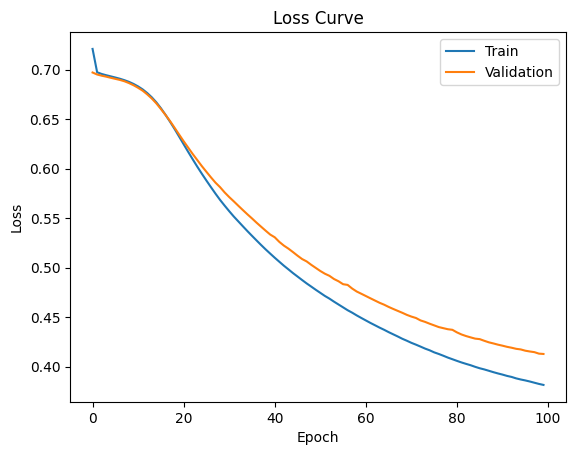

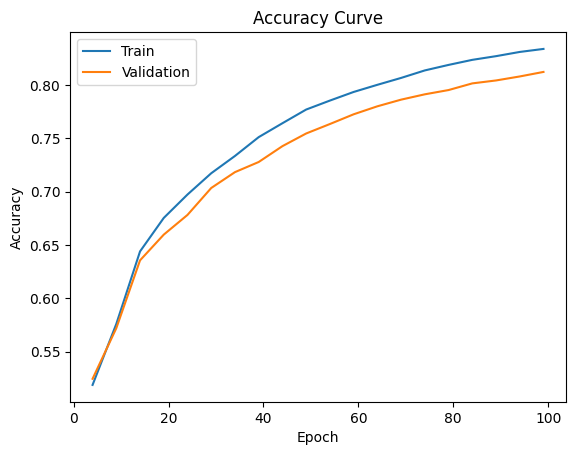

In [ ]:
model = SentimentRNN(vocab_size=1001)
train_network(model, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)

In [ ]:
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss/len(train_loader))

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target.long())
                valid_loss += loss.item()
        valid_losses.append(valid_loss/len(valid_loader))

        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader, device))
            valid_acc.append(get_accuracy(model, valid_loader, device))
            print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, train_losses[-1], valid_losses[-1], train_acc[-1], valid_acc[-1]))
        # model weights saving
        if epoch == 79:
            torch.save(model.state_dict(), 'A4-RNN-Yutian_Mei-1010584529.pth')

    # plotting
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 5; Train Loss 0.690489; Val Loss 0.689801; Train Acc 0.561542; Val Acc 0.554250
Epoch 10; Train Loss 0.672650; Val Loss 0.669279; Train Acc 0.625625; Val Acc 0.627000
Epoch 15; Train Loss 0.606632; Val Loss 0.600387; Train Acc 0.706167; Val Acc 0.700875
Epoch 20; Train Loss 0.516678; Val Loss 0.514178; Train Acc 0.753667; Val Acc 0.749500
Epoch 25; Train Loss 0.467439; Val Loss 0.470438; Train Acc 0.782958; Val Acc 0.776250
Epoch 30; Train Loss 0.438570; Val Loss 0.446592; Train Acc 0.797333; Val Acc 0.790250
Epoch 35; Train Loss 0.417773; Val Loss 0.430971; Train Acc 0.811417; Val Acc 0.798750
Epoch 40; Train Loss 0.401790; Val Loss 0.420140; Train Acc 0.820292; Val Acc 0.806750
Epoch 45; Train Loss 0.388602; Val Loss 0.408927; Train Acc 0.827500; Val Acc 0.813875
Epoch 50; Train Loss 0.377576; Val Loss 0.400891; Train Acc 0.833875; Val Acc 0.819625
Epoch 55; Train Loss 0.368362; Val Loss 0.394649; Train Acc 0.840125; Val Acc 0.822625
Epoch 60; Train Loss 0.360459; Val Loss 0.38

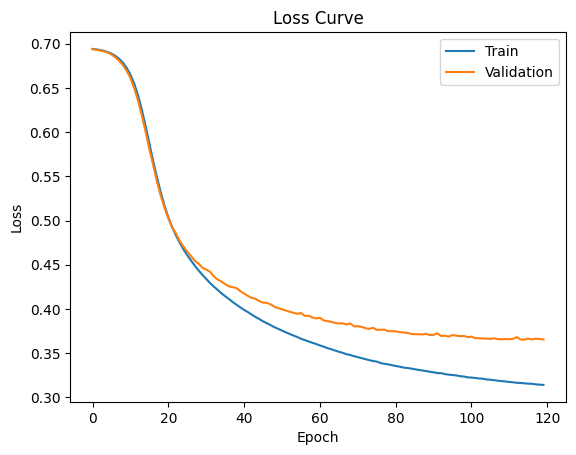

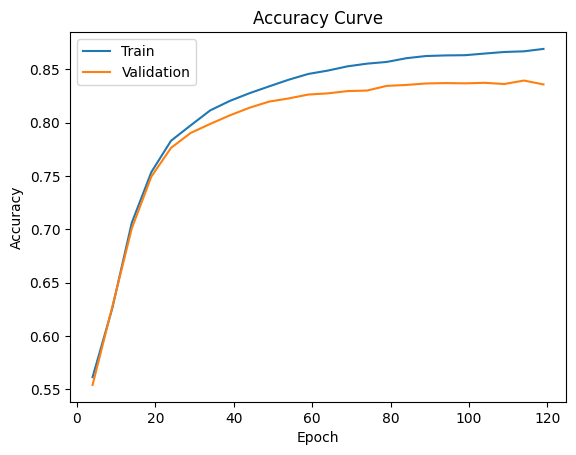

In [ ]:
# Hyperparameters tuning
seq_len = 500
X_train = padding_(X_tr_encoded, seq_len)
X_valid = padding_(X_val_encoded, seq_len)
X_test = padding_(X_te_encoded, seq_len)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
model = SentimentRNN(vocab_size=1001)
train_network(model, train_loader, valid_loader, num_epochs=120, learning_rate=2e-4)


Learning rate: After tuning, I found 2e-4 to be best.
 Further decreasing will result in slower convergence, while further increasing will result in unstable training.
Epoch: After tuning, I found 80 to be best.
 We can see that validation loss and accuracy has become stable after around 80 epochs.
 Less epochs will result in underfitting, while more epochs will result in overfitting.
Batch size: After tuning, I found 32 to be best.
 Smaller batch size will result in longer training time, while larger batch size will result in worse generalization.
Sequence length: After tuning, I found 500 to be best.
 Further decreasing will result in lower validation accuracy (perhaps owning to information loss),
  while further increasing won't improve performance but will require more computation resources.

In [ ]:
# Final test accuracy
model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()

test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cpu")
test_accuracy = get_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")


<ipython-input-60-c809d4f79fcc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))


Test Accuracy: 0.8330


As expected, the final test accuracy of my model is a little bit lower than training and validation accuracy (83.30% vs 85.68% vs 83.44%).
The results reflect that there is neither serious overfitting nor underfitting, which I am happy to see.
Also, as test data was unseen by the model before and test accuracy is close to validation accuracy, it indicates that the model has good generalization ability.

In [ ]:
# Look over misclassified samples
model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()
errors = []
itos = {idx: word for word, idx in stoi.items()} # indices back to words
with torch.no_grad():
  for data, target in test_loader:
    outputs = model(data)
    _, predicted = torch.max(outputs, dim=1)
    j = 0
    for i in range(len(target)):
      if predicted[i] != target[i]:
        input_indices = data[i].cpu().numpy()
        input_words = [itos[idx] for idx in input_indices if idx != 0]
        print(input_words, target[i].item())
        j += 1
        if j == 5:
          break
    if j == 5:
      break

['read', 'novel', 'interest', 'became', 'quite', 'characters', 'tale', 'based', 'br', 'however', 'simply', 'casting', 'based', 'acting', 'talent', 'obvious', 'peter', 'neither', 'able', 'act', 'way', 'attempts', 'french', 'accent', 'hilarious', 'entertaining', 'way', 'found', 'surprised', 'made', 'br', 'fans', 'novel', 'stay', 'away', 'one'] 0.0
['upon', 'time', 'used', 'write', 'doctor', 'whole', 'new', 'american', 'produced', 'doctor', 'soon', 'master', 'going', 'played', 'everyone', 'point', 'imdb', 'came', 'type', 'name', 'one', 'wrote', 'wrote', 'best', 'known', 'role', 'film', 'called', 'school', 'actually', 'looking', 'back', 'best', 'known', 'didnt', 'stop', 'person', 'mind', 'made', 'american', 'master', 'going', 'fans', 'playing', 'master', 'saw', 'doctor', 'great', 'many', 'fans', 'among', 'thought', 'performance', 'best', 'thing', 'american', 'production', 'br', 'br', 'im', 'film', 'wanted', 'see', 'simply', 'first', 'time', 'id', 'heard', 'name', 'didnt', 'get', 'chance', 

<ipython-input-66-a372d8f94575>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))


By printing out some misclassified samples (I printed those words used by model for classification),
 I found that there are likely to be more adjectives with contrary meanings to the original sentiment in these comments.
For example, in the second row printed above, there are words like 'new', 'best', 'master' and so on; in the fifth row, there are words like 'enjoy', 'good' and so on.
However, They are both negative comments.
In the fourth row, there are words like 'hate', wasted' and so on; in the sixth row, there are words like 'horrow', 'strange', 'slow' and so on.
However, they are both positive comments.

In [ ]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. """


In [ ]:
seq_len = 500
tokens = preprocess_sentence(review)
indexed_tokens = [stoi[word] for word in tokens if word in stoi]
padded_tokens = padding_([indexed_tokens], seq_len)
review_tensor = torch.tensor(padded_tokens, dtype=torch.long)

model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()
with torch.no_grad():
  output = model(review_tensor)
  prob = torch.softmax(output, dim=1)
print(f"Probability of positive: {prob[0][1].item()}; negative: {1-prob[0][1].item()}")


Probability of positive: 0.9134528040885925; negative: 0.08654719591140747


Detecting positive and negative reviews is definitely a difficult task.
There are a thousand Hamlets in the eyes of a thousand people, not to say they are discribing them in their own style.

A simple baseline model I can think of is a ANN with embedding layer and fully connected layers.
We may use activation function like sigmoid to generate prediction.
After defining loss function (e.g. BCE), model training can be done through GD and back propagation with the same training and validation set used above.
And finally we can compare the performance on test set of our model with this baseline model.
This simple baseline model may be able to capture some patterns in positive and negative reviews.
But it should not do better than our model.
The difference between the two model's performances can also indicate how well our model is performing.

In [ ]:
# Transfer learning
# install relevant libraries
!pip install -qq transformers

In [ ]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the above code we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

In [ ]:
# Data loading
df = pd.read_csv("IMDB Dataset.csv")
df_train, df_vt = train_test_split(df, test_size=0.6, random_state=0)
df_valid, df_test = train_test_split(df_vt, test_size=0.5, random_state=0)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):
    def __init__(
        self,
        reviews,
        targets,
        tokenizer,
        max_len,
        bert_model=None,
        embed_folder='embeddings',
        precompute=True
    ):
        """
        reviews     : array/list of text data
        targets     : array/list of 'positive'/'negative' labels
        tokenizer   : BERT tokenizer
        max_len     : maximum sequence length for tokenization
        bert_model  : a BERT model for generating embeddings (if precompute=True)
        embed_folder: folder to store .pt files of precomputed embeddings
        precompute  : True -> generate & save embeddings, False -> load from disk only
        """
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.bert_model = bert_model
        self.embed_folder = embed_folder
        self.precompute = precompute

        # Create the folder if it doesn't exist
        if not os.path.exists(self.embed_folder):
            os.makedirs(self.embed_folder)

        if self.precompute and (self.bert_model is not None):
            self._precompute_embeddings()

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        """
        Returns a dictionary with:
          - 'review_text'   : original text (optional, for reference)
          - 'pooled_output' : [768]-dim embedding from BERT
          - 'last_hidden'   : [seq_len, 768] from the last hidden layer
          - 'targets'       : 0 or 1
        """
        review = str(self.reviews[idx])
        target = 1 if self.targets[idx] == 'positive' else 0

        embed_path = os.path.join(self.embed_folder, f'embedding_{idx}.pt')
        # Load precomputed embeddings
        embedding_dict = torch.load(embed_path)

        return {
            'review_text': review,
            'pooled_output': embedding_dict['pooled'],
            'last_hidden': embedding_dict['last'],
            'targets': torch.tensor(target, dtype=torch.long)
        }


    def _precompute_embeddings(self, batch_size=256, device="cuda"):
        """
        Precompute embeddings in batches rather than one by one.
        """
        # Move the model to device (CPU/GPU)
        self.bert_model = self.bert_model.to(device)
        self.bert_model.eval()

        print("Precomputing BERT embeddings (batched)...")

        # 1) Tokenize everything
        encodings = [self.tokenizer.encode_plus(
            str(review),
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        ) for review in self.reviews]
        input_ids = torch.cat([e['input_ids'] for e in encodings], dim=0)
        attention_masks = torch.cat([e['attention_mask'] for e in encodings], dim=0)

        # 2) Create a TensorDataset and DataLoader
        dataset_tensors = TensorDataset(input_ids, attention_masks)
        dataloader = DataLoader(dataset_tensors, batch_size=batch_size, shuffle=False)

        # We'll need to index back into `self.reviews` to save each sample’s .pt
        idx_offset = 0

        for batch in tqdm(dataloader, total=len(dataloader)):
            input_ids, attention_mask = [t.to(device) for t in batch]

            with torch.no_grad():
                outputs = self.bert_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )
            # outputs.pooler_output.shape is [batch_size, hidden_dim]
            # outputs.hidden_states[-1].shape is [batch_size, seq_len, hidden_dim]

            pooled_output_batch = outputs.pooler_output.detach().cpu()
            last_hidden_batch = outputs.hidden_states[-1].detach().cpu()

            # 3) Save each sample in the batch
            for i in range(len(input_ids)):
                sample_idx = idx_offset + i
                embed_path = os.path.join(self.embed_folder, f'embedding_{sample_idx}.pt')

                # Skip if already exists (optional check)
                if os.path.isfile(embed_path):
                    continue

                embedding_dict = {
                    'pooled': pooled_output_batch[i].detach().cpu().clone(),
                    'last': last_hidden_batch[i].detach().cpu().clone()
                }

                torch.save(embedding_dict, embed_path)

            idx_offset += len(input_ids)

        print("Done precomputing embeddings.")


In [ ]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 32

#training data
train_dataset = MovieReviewDataset(
    reviews=df_train['review'].values,
    targets=df_train['sentiment'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    bert_model=bert_model,       # required if we want to precompute now
    embed_folder='train_embeds', # folder to save embeddings
    precompute=True              # set to True so we generate them
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
) #modify num_works as needed


#validation data

valid_dataset = MovieReviewDataset(
    reviews=df_valid['review'].values,
    targets=df_valid['sentiment'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    bert_model=bert_model,
    embed_folder='valid_embeds',
    precompute=True
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)

#test data

test_dataset = MovieReviewDataset(
    reviews=df_test['review'].values,
    targets=df_test['sentiment'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    bert_model=bert_model,
    embed_folder='test_embeds',
    precompute=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)


Precomputing BERT embeddings (batched)...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 63/63 [07:15<00:00,  6.91s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze 

Done precomputing embeddings.
Precomputing BERT embeddings (batched)...


100%|██████████| 47/47 [05:31<00:00,  7.05s/it]


Done precomputing embeddings.
Precomputing BERT embeddings (batched)...


100%|██████████| 47/47 [05:36<00:00,  7.15s/it]

Done precomputing embeddings.


In [ ]:
# Take a look at one sample

for sample in train_data_loader:
  print("Text:")
  for text in sample['review_text']:
    print(text)
  print("Pooled Output:", sample['pooled_output'].shape)
  print("Last Hidden:", sample['last_hidden'].shape)
  print("Targets:", sample['targets'])
  break


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Text:
The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.<br /><br />It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.<br /><br />I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies.
Life Begins - and ends - in a typical 1930's maternity / recovery ward, where we view 48 hours in the lives of several high risk pregnant women, played by Loretta Young, Glenda Farrell, Clara Blandick (Aunty Em???), Vivienne Osborne, Dorothy Tree, and Gloria Shea, as they await to give birth. While the film features plot devices which see

train_data_loader: 'review_text': a list for original text;
 'pooled_output': [768]-dim embedding from BERT;
 'last_hidden': [seq_len, 768] from the last hidden layer of BERT;
 'targets': labels (0 for negative, 1 for positive).

In [ ]:
# Range of token values
min_token, max_token = float('inf'), float('-inf')
for sample in train_data_loader:
  last_hidden = sample['last_hidden']
  token = last_hidden.flatten().tolist()
  min_token, max_token = min(min_token, min(token)), max(max_token, max(token))
print("Range of token values:", min_token, 'to', max_token)


Range of token values: -9.89176082611084 to 7.872392177581787


Firstly, the tokenizer is initialized by pretrained BERT.
Then it converts text into numerical tokens that BERT can understand.
After that, the tokenized IDs are fed into BERT to generate embeddings.
So by extracting the last hidden state from precomputed embeddings, we can convert it into token values.

In [ ]:
# Histograms
tokens = []
for sample in train_data_loader:
  last_hidden = sample['last_hidden'].flatten().tolist()
  tokens.extend(last_hidden)
plt.hist(tokens, bins=100, alpha=0.5)
plt.xlabel("Token values")
plt.ylabel("Frequency")
plt.title("Training Data")
plt.show()

tokens = []
for sample in valid_data_loader:
  last_hidden = sample['last_hidden'].flatten().tolist()
  tokens.extend(last_hidden)
plt.hist(tokens, bins=100, alpha=0.5)
plt.xlabel("Token values")
plt.ylabel("Frequency")
plt.title("Validation Data")
plt.show()

tokens = []
for sample in test_data_loader:
  last_hidden = sample['last_hidden'].flatten().tolist()
  tokens.extend(last_hidden)
plt.hist(tokens, bins=100, alpha=0.5)
plt.xlabel("Token values")
plt.ylabel("Frequency")
plt.title("Test Data")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from collections import Counter

token_counter = Counter()
for text in df_train['review'].values:
  tokens = tokenizer.tokenize(text)
  token_counter.update(tokens)
top_5_tokens = token_counter.most_common(5)
print("Top 5 occurring tokens:")
for token, count in top_5_tokens:
  print(f"Token: {token}, Count: {count}")


Top 5 occurring tokens:
Token: ., Count: 209365
Token: the, Count: 186465
Token: ,, Count: 175761
Token: a, Count: 101229
Token: and, Count: 100162


Top 5 occuring tokens are printed above.
They are either punctuation marks or empty words that are most commonly used,
 but might have little use for sentiment analysis.

In [ ]:
for sample in train_data_loader:
  print("Pooled Output:", sample['pooled_output'].shape)
  print("Pooled Output:", sample['pooled_output'])
  print("Last Hidden:", sample['last_hidden'].shape)
  print("Last Hidden:", sample['last_hidden'])
  break


Pooled Output: torch.Size([32, 768])
Pooled Output: tensor([[-0.6604,  0.2984,  0.9997,  ...,  0.9999, -0.8279,  0.9786],
        [-0.6063,  0.2938,  0.9995,  ...,  0.9999, -0.6413,  0.9814],
        [-0.2810,  0.2217,  0.9963,  ...,  0.9992, -0.9338,  0.9577],
        ...,
        [-0.7672,  0.4464,  0.9999,  ...,  1.0000, -0.3439,  0.9821],
        [-0.7146,  0.4268,  0.9997,  ...,  0.9999, -0.3357,  0.9761],
        [-0.8178,  0.4087,  0.9998,  ...,  0.9999, -0.0922,  0.9777]])
Last Hidden: torch.Size([32, 400, 768])
Last Hidden: tensor([[[ 5.2496e-01,  6.0587e-02, -1.5166e-01,  ..., -1.7546e-01,
           3.1312e-01,  1.4122e-01],
         [ 1.4004e-01, -5.5314e-01,  3.0105e-01,  ..., -1.6027e-01,
           2.5123e-01,  2.2539e-01],
         [ 2.2665e-01, -4.7405e-02,  7.4681e-02,  ...,  3.6010e-01,
           3.4568e-01, -1.6381e-01],
         ...,
         [ 1.3595e-02,  2.0125e-01, -1.8064e-01,  ...,  1.2063e-01,
          -6.3830e-02,  4.6668e-01],
         [ 7.9451e-02,  2.9

pooled_output: [batch_size, hidden_size]
last_hidden: [batch_size, sequence_length, hidden_size]
Batch size and sequence length are defined in advance and can be modified by us.
Hidden size is determined by the characteristic of BERT, which is fixed (768).

In [ ]:
class BaselineSentimentClassifierPooled(nn.Module):
    def __init__(self, n_classes):
        super(BaselineSentimentClassifierPooled, self).__init__()
        self.linear = nn.Linear(768, n_classes)

    def forward(self, pooled_embedding):
        outputs = self.linear(pooled_embedding)
        return outputs


In [ ]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierPooled, self).__init__()

    self.fc1 = nn.Linear(768, 256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.1)
    self.fc2 = nn.Linear(256, n_classes)

  def forward(self, pooled_embedding):

    x = self.fc1(pooled_embedding)
    x = self.relu(x)
    x = self.dropout(x)
    outputs = self.fc2(x)

    return outputs


In [ ]:
class BaselineSentimentClassifierLast(nn.Module):
    def __init__(self, n_classes):
        super(BaselineSentimentClassifierLast, self).__init__()

        self.linear = nn.Linear(768, n_classes)


    def forward(self, last_hidden):

        x, _ = torch.max(last_hidden, dim=1)
        x = self.dropout(x)
        outputs = self.linear(x)
        return outputs


In [ ]:
class SentimentClassifierLast(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierLast, self).__init__()

    self.fc1 = nn.Linear(768, 256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.1)
    self.fc2 = nn.Linear(256, n_classes)


  def forward(self, last_hidden):

    x, _ = torch.max(last_hidden, dim=1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    outputs = self.fc2(x)

    return outputs

In [ ]:
def get_accuracy(model, data_loader, device, use_pooled=True):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """

    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
      for batch in data_loader:
        data = batch["pooled_output" if use_pooled else "last_hidden"].to(device)
        target = batch["targets"].to(device)
        output = model(data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.shape[0]
    return correct / total


In [ ]:
# Model training

def train_model(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5, use_pooled=True):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            data = batch['pooled_output' if use_pooled else 'last_hidden'].to(device)
            target = batch['targets'].to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss/len(train_loader))

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                data = batch['pooled_output' if use_pooled else 'last_hidden'].to(device)
                target = batch['targets'].to(device)
                pred = model(data)
                loss = criterion(pred, target.long())
                valid_loss += loss.item()
        valid_losses.append(valid_loss/len(valid_loader))

        train_acc.append(get_accuracy(model, train_loader, device, use_pooled))
        valid_acc.append(get_accuracy(model, valid_loader, device, use_pooled))
        print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, train_losses[-1], valid_losses[-1], train_acc[-1], valid_acc[-1]))

        # model weights saving
        if epoch == 9:
            torch.save(model.state_dict(), 'A4-BERT-Yutian_Mei-1010584529.pth')

    # plotting
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1; Train Loss 0.673322; Val Loss 0.642478; Train Acc 0.671937; Val Acc 0.665167
Epoch 2; Train Loss 0.618763; Val Loss 0.610576; Train Acc 0.632812; Val Acc 0.631917
Epoch 3; Train Loss 0.561783; Val Loss 0.577509; Train Acc 0.682500; Val Acc 0.673500
Epoch 4; Train Loss 0.520313; Val Loss 0.570598; Train Acc 0.692438; Val Acc 0.681417
Epoch 5; Train Loss 0.491889; Val Loss 0.529883; Train Acc 0.736938; Val Acc 0.728250
Epoch 6; Train Loss 0.473113; Val Loss 0.521661; Train Acc 0.746000; Val Acc 0.735167
Epoch 7; Train Loss 0.460472; Val Loss 0.504194; Train Acc 0.760375; Val Acc 0.749167
Epoch 8; Train Loss 0.452263; Val Loss 0.503885; Train Acc 0.762563; Val Acc 0.751250
Epoch 9; Train Loss 0.444480; Val Loss 0.485265; Train Acc 0.778563; Val Acc 0.765750
Epoch 10; Train Loss 0.439750; Val Loss 0.494449; Train Acc 0.771687; Val Acc 0.759750
Epoch 11; Train Loss 0.436391; Val Loss 0.479841; Train Acc 0.783312; Val Acc 0.771167
Epoch 12; Train Loss 0.431242; Val Loss 0.479158; Tr

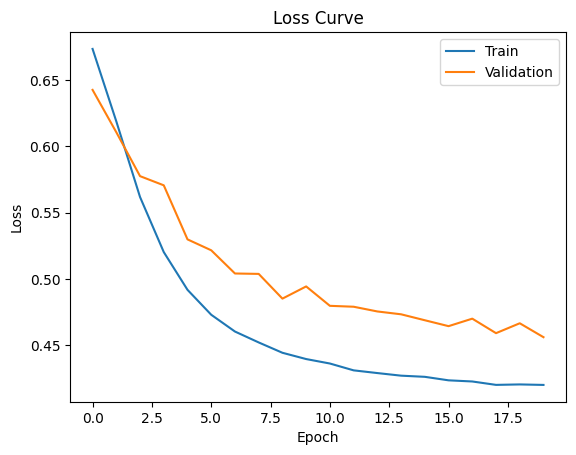

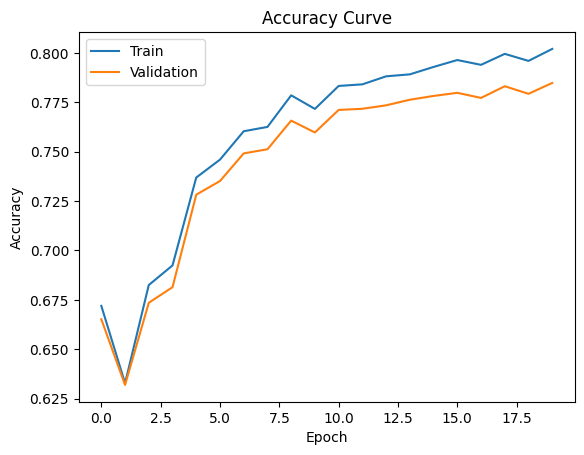

In [ ]:
model_last = SentimentClassifierLast(n_classes=2)
train_model(model_last, train_data_loader, valid_data_loader, num_epochs=20, learning_rate=1e-4, use_pooled=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1; Train Loss 0.640366; Val Loss 0.608566; Train Acc 0.675625; Val Acc 0.677917
Epoch 2; Train Loss 0.585437; Val Loss 0.574606; Train Acc 0.709375; Val Acc 0.702083
Epoch 3; Train Loss 0.557534; Val Loss 0.548848; Train Acc 0.728938; Val Acc 0.721917
Epoch 4; Train Loss 0.537973; Val Loss 0.530760; Train Acc 0.743375; Val Acc 0.737667
Epoch 5; Train Loss 0.523957; Val Loss 0.520185; Train Acc 0.751500; Val Acc 0.746333
Epoch 6; Train Loss 0.513674; Val Loss 0.510232; Train Acc 0.756875; Val Acc 0.751750
Epoch 7; Train Loss 0.507089; Val Loss 0.501150; Train Acc 0.762875; Val Acc 0.760500
Epoch 8; Train Loss 0.502386; Val Loss 0.499801; Train Acc 0.763625; Val Acc 0.762167
Epoch 9; Train Loss 0.497539; Val Loss 0.492462; Train Acc 0.768750; Val Acc 0.766583
Epoch 10; Train Loss 0.493351; Val Loss 0.489904; Train Acc 0.769437; Val Acc 0.768333


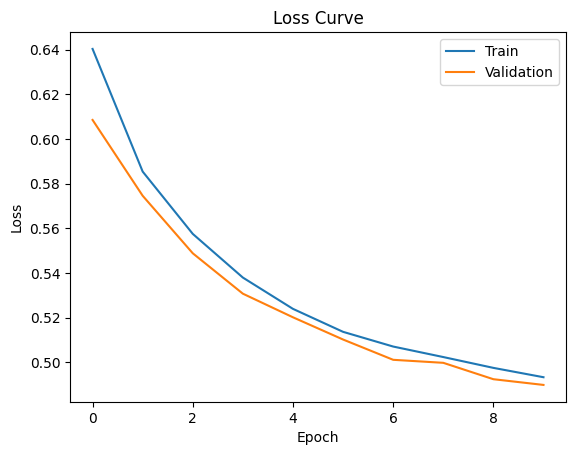

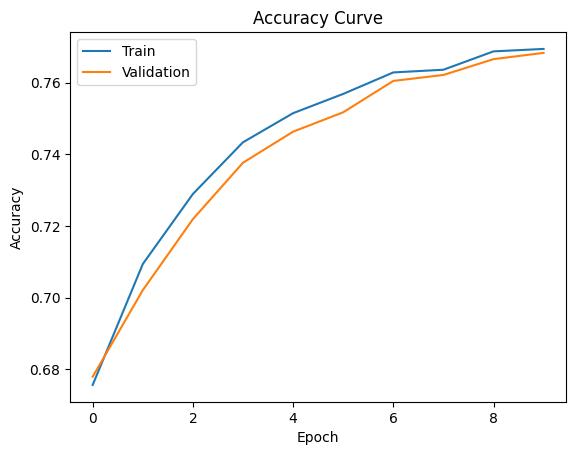

In [ ]:
# Hyperparameters tuning

model_pooled = SentimentClassifierPooled(n_classes=2)
train_model(model_pooled, train_data_loader, valid_data_loader, num_epochs=10, learning_rate=1e-4, use_pooled=True)

I tried to tune a couple of different hyperparameters above.
But as the training time was far too long (2hrs for 10 epochs), I could not reach the best possible results.
SentimentClassifierPooled and SentimentClassifierLast after 10 epochs of training have achieved similar accuracy.
While the former is a little bit higher on validation set, I have chosen and saved it as the BERT model in this part.
The hyperparameters are chosen as follows:
Learning rate: 1e-4.
 Further decreasing will result in slower convergence, while further increasing will result in unstable training.
Epoch: 10.
 We can see that validation loss and accuracy has become stable after around 10 epochs.
 Less epochs will result in underfitting, while more epochs will result in overfitting.
Batch size: 32.
 Smaller batch size will result in longer training time, while larger batch size will result in worse generalization.
Hidden size: 256.
 Larger hidden size will likely to result in overfitting and increase training time, while smaller hidden size will decrease accuracy.
 As the input size is 768, decreasing it into a little less than half is a proper choice.

In [ ]:
# Final test accuracy
model = SentimentClassifierPooled(n_classes=2)
model.load_state_dict(torch.load('A4-BERT-Yutian_Mei-1010584529.pth'))
model.eval()
device = torch.device("cpu")
test_accuracy = get_accuracy(model, test_data_loader, device, use_pooled=True)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.7693


In [ ]:
accs = {
  'Model': ['RNN', 'RNN', 'RNN', 'BERT', 'BERT', 'BERT'],
  'Dataset': ['Training', 'Validation', 'Test', 'Training', 'Validation', 'Test'],
  'Accuracy': [0.8568, 0.8344, 0.8330, 0.7694, 0.7683, 0.7693]
}
df_accs = pd.DataFrame(accs)
df_accs

,Model,Dataset,Accuracy
0,RNN,Training,0.8568
1,RNN,Validation,0.8344
2,RNN,Test,0.8330
3,BERT,Training,0.7694
4,BERT,Validation,0.7683
5,BERT,Test,0.7693


The RNN model with GRU in Part A has performed better than the BERT model in Part B in all three datasets.
I did not expect these results, as I thought transfer learning would help us achieve higher accuracys.
But it is to some extent reasonable as I only runned 10 epochs for the BERT model (it takes too long to train).
The performance of BERT model will be likely to further improve with more training time and perhaps better hyperparameters tuning.
For both models, test accuracy is close to validation accuracy, which indicates that they have good generalization and are not overfitting.

In [ ]:
# Performance on test set

# RNN
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()
device = torch.device("cpu")
fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for data, target in train_loader:
    data, targets = data.to(device), target.to(device)
    output = model(data)
    _, preds = torch.max(output, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
train_fpr_RNN, train_fnr_RNN = fp / (fp + tn), fn / (fn + tp)

fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for data, target in valid_loader:
    data, targets = data.to(device), target.to(device)
    output = model(data)
    _, preds = torch.max(output, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
valid_fpr_RNN, valid_fnr_RNN = fp / (fp + tn), fn / (fn + tp)

fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for data, target in test_loader:
    data, targets = data.to(device), target.to(device)
    output = model(data)
    _, preds = torch.max(output, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
test_fpr_RNN, test_fnr_RNN = fp / (fp + tn), fn / (fn + tp)

# BERT
model = SentimentClassifierPooled(n_classes=2)
model.load_state_dict(torch.load('A4-BERT-Yutian_Mei-1010584529.pth'))
model.eval()
device = torch.device("cpu")
fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for batch in train_data_loader:
    data = batch['pooled_output'].to(device)
    targets = batch['targets'].to(device)
    outputs = model(data)
    _, preds = torch.max(outputs, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
train_fpr_BERT, train_fnr_BERT = fp / (fp + tn), fn / (fn + tp)

fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for batch in valid_data_loader:
    data = batch['pooled_output'].to(device)
    targets = batch['targets'].to(device)
    outputs = model(data)
    _, preds = torch.max(outputs, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
valid_fpr_BERT, valid_fnr_BERT = fp / (fp + tn), fn / (fn + tp)

fp, fn, tp, tn = 0, 0, 0, 0
with torch.no_grad():
  for batch in test_data_loader:
    data = batch['pooled_output'].to(device)
    targets = batch['targets'].to(device)
    outputs = model(data)
    _, preds = torch.max(outputs, dim=1)

    tp += torch.sum((preds == 1) & (targets == 1)).item()
    fp += torch.sum((preds == 1) & (targets == 0)).item()
    tn += torch.sum((preds == 0) & (targets == 0)).item()
    fn += torch.sum((preds == 0) & (targets == 1)).item()
test_fpr_BERT, test_fnr_BERT = fp / (fp + tn), fn / (fn + tp)

results = {
  'Model - Dataset': ['RNN - Training', 'RNN - Validation', 'RNN - Test', 'BERT - Training', 'BERT - Validation', 'BERT - Test'],
  'False Positive Rate': [train_fpr_RNN, valid_fpr_RNN, test_fpr_RNN, train_fpr_BERT, valid_fpr_BERT, test_fpr_BERT],
  'False Negative Rate': [train_fnr_RNN, valid_fnr_RNN, test_fnr_RNN, train_fnr_BERT, valid_fnr_BERT, test_fnr_BERT]
}
df_results = pd.DataFrame(results)
df_results

,Model - Dataset,False Positive Rate,False Negative Rate
0,RNN - Training,0.131445,0.154907
1,RNN - Validation,0.153732,0.177716
2,RNN - Test,0.157908,0.176074
3,BERT - Training,0.270852,0.190304
4,BERT - Validation,0.271529,0.191911
5,BERT - Test,0.268187,0.193059


From the results above, we can tell that the two models are functioning quite differently,
 as for RNN with GRU, false positive rates for all 3 sets are lower than false negative rates,
 and for BERT, false negative rates for all 3 sets are lower than false positive.
That indicates that RNN is good at identifying positive reviews, while BERT is good at identifying negative reviews.
Once again, both models have similar FPR/FNR across all three sets, which indicates they both have good generalization and are not overfitting.

In [ ]:
# Examination

# the 18-th review in IMDB dataset.csv
review = """
I was first introduced to John Waters films by seeing "Female trouble" on IFC. I was disgusted but for some sick reason i enjoyed it. Then, i picked up the Pink Flamingos DVD in the John Waters Boxed Set. The movie is about Babs Johnson "The Filthiest Person Alive" who lives in a trailer in Maryland with her obese egg obsessed mother,and her deranged son "Crackers". In the movie you will see such sick sights as sex with chickens, drag-queens, people eating feces, torture, and all other sorts of random humiliation. The film has a soundtrack from 60's rock and roll artists. The only problem is that some parts of the film seem to drag on and can get a little boring. I found "Female Trouble" a little more fun. Rated NC-17 for Explicit sex, violence, and disturbing images. Enjoy.
"""

seq_len = 500
tokens = preprocess_sentence(review)
indexed_tokens = [stoi[word] for word in tokens if word in stoi]
padded_tokens = padding_([indexed_tokens], seq_len)
review_tensor = torch.tensor(padded_tokens, dtype=torch.long)

model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()
with torch.no_grad():
  output = model(review_tensor)
  prob = torch.softmax(output, dim=1)
print(f"Probability of positive - initial review: {prob[0][1].item()}; negative: {1-prob[0][1].item()}")

review_modified = """
I was first introduced to John Waters films by seeing "Female trouble" on IFC. I enjoyed it. Then, i picked up the Pink Flamingos DVD in the John Waters Boxed Set. The movie is about Babs Johnson "The Filthiest Person Alive" who lives in a trailer in Maryland with her obese egg obsessed mother,and her deranged son "Crackers". In the movie you will see such sick sights as sex with chickens, drag-queens, people eating feces, torture, and all other sorts of random humiliation. The film has a soundtrack from 60's rock and roll artists. The only problem is that some parts of the film seem to drag on and can get a little boring. I found "Female Trouble" a little more fun. Rated NC-17 for Explicit sex, violence, and disturbing images. Enjoy.
"""

seq_len = 500
tokens = preprocess_sentence(review_modified)
indexed_tokens = [stoi[word] for word in tokens if word in stoi]
padded_tokens = padding_([indexed_tokens], seq_len)
review_tensor = torch.tensor(padded_tokens, dtype=torch.long)

model = SentimentRNN(vocab_size=1001)
model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
model.eval()
with torch.no_grad():
  output = model(review_tensor)
  prob = torch.softmax(output, dim=1)
print(f"Probability of positive - after modification: {prob[0][1].item()}; negative: {1-prob[0][1].item()}")

Probability of positive - initial review: 0.40903735160827637; negative: 0.5909626483917236
Probability of positive - after modification: 0.5889919996261597; negative: 0.41100800037384033


In [ ]:
# the 3-rd review in IMDB dataset.csv
review = """
The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.<br /><br />It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.<br /><br />I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies.
"""

inputs = tokenizer(
    review,
    return_tensors='pt',
    truncation=True,
    padding=True,
    max_length=400
)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

device = torch.device('cpu')
bert_model = bert_model.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
with torch.no_grad():
  outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
  pooled_output = outputs.pooler_output

model = SentimentClassifierPooled(n_classes=2)
model.load_state_dict(torch.load('A4-BERT-Yutian_Mei-1010584529.pth'))
model.eval()
model = model.to(device)
pooled_output = pooled_output.to(device)
with torch.no_grad():
  output = model(pooled_output)
  prob = torch.softmax(output, dim=-1)
print(f"Probability of positive - before modification: {prob[0][1].item()}; negative: {1-prob[0][1].item()}")

review_modified = """
The film with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.<br /><br />It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.<br /><br />I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies.
"""
inputs = tokenizer(
    review_modified,
    return_tensors='pt',
    truncation=True,
    padding=True,
    max_length=400
)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

device = torch.device('cpu')
bert_model = bert_model.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
with torch.no_grad():
  outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
  pooled_output = outputs.pooler_output

model = SentimentClassifierPooled(n_classes=2)
model.load_state_dict(torch.load('A4-BERT-Yutian_Mei-1010584529.pth'))
model.eval()
model = model.to(device)
pooled_output = pooled_output.to(device)
with torch.no_grad():
  output = model(pooled_output)
  prob = torch.softmax(output, dim=-1)
print(f"Probability of positive - after modification: {prob[0][1].item()}; negative: {1-prob[0][1].item()}")

Probability of positive - before modification: 0.5923969745635986; negative: 0.40760302543640137
Probability of positive - after modification: 0.48579156398773193; negative: 0.5142084360122681


According to the structure and character differences in both models, RNN with GRU has limited capability for feature extraction and long-distance dependencies,
 while BERT depends on the similarities between pretraining data and training data, and is sensitive to noise.
So we can see that two models are performing quite differently and each has its own weaknesses.

As shown above, initially the positive review was misclassified by RNN model, and the negative review was misclassified by BERT model.
After some modification, both models are able to classify it correctly.
In fact, I just deleted the phrase 'was disgusted but for some sick reason' in the first one and the phrase 'quickly gets to a major chase scene'.
The two words 'disgusted' and 'sick' are usually used to express negative sentiments, but here we can easily tell that they are just emphasizing.
And 'quickly gets to a major' is usually a praise, but the key point is 'destruction'.
However, they have greatly impacted the judgement of the models.

In [ ]:
# Tested on new data

REV = ["""I can't remember the last time I was so invested in a TV show. I was hooked from the first episode, and constantly impressed with the directing, visuals, acting, and plot developments. It's like a cross between Black Mirror and 1984, but it might be better than both of those works of art. This is truly something special and I COULD NOT be more excited for season 2.""",
       """Severance is every bit as good as everyone says it is. All you have to do is read through the reviews and look the rating to see how much people think of this series. It's on every "best shows of 2022" list out there for a reason and will absolutely be nominated for a ton of awards! Adam Scott leads an amazing cast who all do a fantastic job. It's just such an original show that will keep you wanting more. The first episode may start a little slow for some but stick with it because I promise that you won't regret it. If you stay with it I guarantee it will become one of your favorite shows of the year. I'm so glad they already decided to pick it up for future seasons!""",
       """There really aren't enough positive things to say about this potential masterpiece of art. I want to go on record as saying if the show manages to keep this quality up for it's entire run length, this will be the first show I have watched since Breaking Bad to be as close to perfection as possible.
          Admittedly, things start off slow and drag slightly with the first episode. Fear not though, because Severance picks up with an increasing amount of drama and mystery, climaxing perfectly with a season finale that balances that fine line of leaving you wanted more, while quenching your appetite to remain satisfied until Season 2.
          Every metric you can measure and judge a TV show on is on display with absolute mastery. The casting, acting, script, direction, cinematography, lighting, set decoration.. everything is perfect.
          Actually I noticed a running theme for this review I've written is the word "perfect". So I'll leave you all with that, and watch the damn show already.""",
       """The showrunners prioritized impressing critics over delivering a satisfying season for fans who waited three years. Their focus was on showcasing cinematography rather than crafting a compelling story that progresses naturally. After 9 episodes in Season 2, we're left with more questions than answers. What should be an engaging experience has instead become a frustrating exercise in deciphering the plot. Watching this is no longer enjoyable.
          The characters feel flat and unrelatable. There's no one to connect with, making it hard to care about what happens to them. Because of this, the story feels empty, making it even harder to stay engaged.""",
       """Very boring and nothing is resolved. If you managed to make it through all 9 hours of monotony, you receive absolutely no payoff. You'll have to wait for season 2. The whole series could have been condensed into a movie."""]

i = 0
for review in REV:
  i += 1
  if i < 4:
    print('Review', i, '- positive')
  else:
    print('Review', i, '- negative')
  seq_len = 500
  tokens = preprocess_sentence(review)
  indexed_tokens = [stoi[word] for word in tokens if word in stoi]
  padded_tokens = padding_([indexed_tokens], seq_len)
  review_tensor = torch.tensor(padded_tokens, dtype=torch.long)

  model = SentimentRNN(vocab_size=1001)
  model.load_state_dict(torch.load('A4-RNN-Yutian_Mei-1010584529.pth'))
  model.eval()
  with torch.no_grad():
    output = model(review_tensor)
    prob = torch.softmax(output, dim=1)
    pred = 'positive' if prob[0][1].item() > 0.5 else 'negative'
    print(f'RNN prediction:', pred)

  inputs = tokenizer(review, return_tensors='pt', truncation=True, padding=True, max_length=400)
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']

  device = torch.device('cpu')
  bert_model = bert_model.to(device)
  input_ids = input_ids.to(device)
  attention_mask = attention_mask.to(device)
  with torch.no_grad():
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output

  model = SentimentClassifierPooled(n_classes=2)
  model.load_state_dict(torch.load('A4-BERT-Yutian_Mei-1010584529.pth'))
  model.eval()
  model = model.to(device)
  pooled_output = pooled_output.to(device)
  with torch.no_grad():
    output = model(pooled_output)
    prob = torch.softmax(output, dim=1)
    pred = 'positive' if prob[0][1].item() > 0.5 else 'negative'
    print(f'BERT prediction:', pred)


Review 1 - positive
RNN prediction: positive
BERT prediction: positive
Review 2 - positive
RNN prediction: positive
BERT prediction: positive
Review 3 - positive
RNN prediction: positive
BERT prediction: positive
Review 4 - negative
RNN prediction: negative
BERT prediction: positive
Review 5 - negative
RNN prediction: negative
BERT prediction: negative


I collected 5 recent reviews (3 positive, 2 negative) on the episode 'Severance', which I enjoyed a lot.
The RNN model successfully predicted the sentiment of all 5 reviews, while the BERT model predicted 4 out of 5.
This corresponds to the results above, where the false positive rate of BERT model is quite high.
Overall, I am happy with the results, as they indicate that both models generalize well to new data.

Epoch 1; Train Loss: 2.2929; Val Loss: 1.9106
Epoch 2; Train Loss: 1.7925; Val Loss: 1.7239
Epoch 3; Train Loss: 1.6610; Val Loss: 1.6330
Epoch 4; Train Loss: 1.5881; Val Loss: 1.5877
Epoch 5; Train Loss: 1.5438; Val Loss: 1.5453
Epoch 6; Train Loss: 1.5074; Val Loss: 1.5212
Epoch 7; Train Loss: 1.4806; Val Loss: 1.4935
Epoch 8; Train Loss: 1.4628; Val Loss: 1.4820
Epoch 9; Train Loss: 1.4437; Val Loss: 1.4662
Epoch 10; Train Loss: 1.4258; Val Loss: 1.4510
Epoch 11; Train Loss: 1.4150; Val Loss: 1.4431
Epoch 12; Train Loss: 1.4023; Val Loss: 1.4324
Epoch 13; Train Loss: 1.3914; Val Loss: 1.4210
Epoch 14; Train Loss: 1.3848; Val Loss: 1.4190
Epoch 15; Train Loss: 1.3749; Val Loss: 1.4129
Epoch 16; Train Loss: 1.3712; Val Loss: 1.4018
Epoch 17; Train Loss: 1.3620; Val Loss: 1.3973
Epoch 18; Train Loss: 1.3561; Val Loss: 1.3913
Epoch 19; Train Loss: 1.3508; Val Loss: 1.3924
Epoch 20; Train Loss: 1.3431; Val Loss: 1.3855


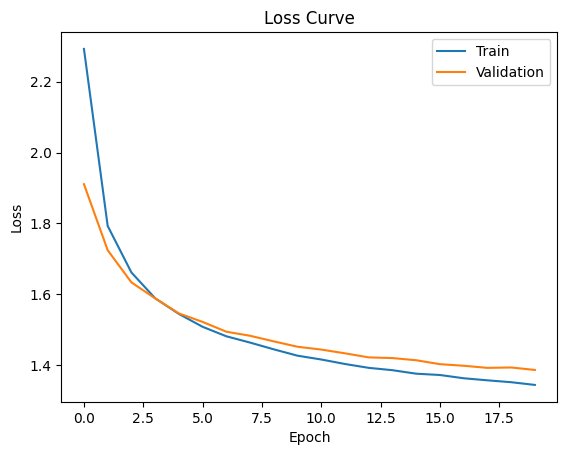

In [ ]:
# Generative character-level LSTM model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

df = pd.read_csv("IMDB Dataset.csv")
df_train, df_vt = train_test_split(df, test_size=0.6, random_state=0)
df_valid, df_test = train_test_split(df_vt, test_size=0.5, random_state=0)

# preprocessing
def preprocess_text(texts):
  text = " ".join(texts).lower()
  chars = sorted(list(set(text)))
  stoi = {ch: i for i, ch in enumerate(chars)}
  itos = {i: ch for ch, i in stoi.items()}
  return stoi, itos, len(chars)
train_texts = df_train['review'].tolist()
stoi, itos, vocab_size = preprocess_text(train_texts)
encoded_texts = [[stoi[ch] for ch in text.lower()] for text in train_texts]

class CharDataset(Dataset):
  def __init__(self, texts, seq_length=100):
    self.texts = texts
    self.seq_length = seq_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    if len(text) <= self.seq_length:
      input_seq = torch.tensor(text + [0] * (self.seq_length - len(text)), dtype=torch.long)
      target_seq = torch.tensor(text[1:] + [0] * (self.seq_length - len(text) + 1), dtype=torch.long)
    else:
      start_idx = torch.randint(0, len(text) - self.seq_length, (1,)).item()
      input_seq = torch.tensor(text[start_idx:start_idx+self.seq_length], dtype=torch.long)
      target_seq = torch.tensor(text[start_idx+1:start_idx+self.seq_length+1], dtype=torch.long)
    return input_seq, target_seq

seq_length = 100
train_dataset = CharDataset(encoded_texts, seq_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_texts = df_valid['review'].tolist()
encoded_valid_texts = []
for text in valid_texts:
  encoded_text = []
  for ch in text.lower():
    if ch in stoi:
      encoded_text.append(stoi[ch])
    else:
      encoded_text.append(stoi.get(' ', 0))
  encoded_valid_texts.append(encoded_text)
valid_dataset = CharDataset(encoded_valid_texts, seq_length)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# generative character-level LSTM model
class CharLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
    super(CharLSTM, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, x, hidden):
    x = self.embedding(x)
    out, hidden = self.lstm(x, hidden)
    out = self.fc(out)
    return out, hidden

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharLSTM(vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# calculating validation loss
def validate_model(model, data_loader):

  model.eval()
  total_loss = 0
  total_batches = 0

  with torch.no_grad():
    hidden = None
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs, hidden = model(inputs, hidden)
      loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
      total_loss += loss.item()
      total_batches += 1

  return total_loss / total_batches

def train_model(model, train_loader, valid_loader, epochs=10):

  avg_train_loss, avg_valid_loss = [], []
  for epoch in range(epochs):

    train_loss, train_batches = 0, 0
    for batch, (inputs, targets) in enumerate(train_loader):
      model.train()
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      hidden = None
      outputs, hidden = model(inputs, hidden)
      loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_batches += 1

    avg_train_loss.append(train_loss / train_batches)
    avg_valid_loss.append(validate_model(model, valid_loader))
    print(f"Epoch {epoch+1}; Train Loss: {avg_train_loss[-1]:.4f}; Val Loss: {avg_valid_loss[-1]:.4f}")

  # plotting
  plt.title("Loss Curve")
  plt.plot(avg_train_loss, label="Train")
  plt.plot(avg_valid_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

train_model(model, train_loader, valid_loader, epochs=20)


In [ ]:
def generate_text(model, start_text, length=500, temperature=1.0):
  model.eval()
  generated_text = start_text.lower()
  input_seq = torch.tensor([[stoi[ch] for ch in generated_text]], dtype=torch.long).to(device)
  hidden = None

  for _ in range(length):
    with torch.no_grad():
      outputs, hidden = model(input_seq, hidden)
      probs = torch.softmax(outputs[:, -1, :] / temperature, dim=-1)
      next_char_idx = torch.multinomial(probs, 1).item()
      next_char = itos[next_char_idx]
      generated_text += next_char
      input_seq = torch.cat((input_seq[:, 1:], torch.tensor([[next_char_idx]], device=device)), dim=1)  # 更新输入序列

  return generated_text

start_text = "The movie is"
generated_review = generate_text(model, start_text, length=200, temperature=0.8)
print(f"Generated Review :{generated_review}")

Generated Review :the movie is so intentivels and best. and and it should have been hard of sake somewhere to make it a new opera and "explandside dentinues early too which started essence is the distankly video and reindand. stra


I constructed a generative character-level LSTM model by modifying the code provided in Pre4B.
generate_text is coded with the help of AI.
We can see that the training has converged at around 10 epochs.
After 20 epochs of training, the model is able to generate some weird sentences, which are not comparable to those from LLMs.